## Setup

In [1]:
import numpy as np
import time
import json
import requests
import boto3
import os
import sagemaker
import io

In [2]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

In [3]:
from time import strftime,gmtime

In [4]:
import matplotlib.pyplot as plt
import cv2

In [5]:
import boto3
sns_client = boto3.client('sns')

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
from sagemaker import get_execution_role, Session, image_uris

role = get_execution_role()
sess = Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
sm_client = boto3.client("sagemaker", region_name=region)

In [7]:
boto_session = boto3.session.Session()
sm_runtime = boto_session.client("sagemaker-runtime")

## Load model from Torch Hub

In [ ]:
#!pip install timm

In [ ]:
#import torch

In [ ]:
#model_type= 'DPT_Large'

#midas= torch.hub.load("intel-isl/MiDaS", model_type)

### Create model archive

In [8]:
model_archive_name = 'MiDaS.tar.gz'

In [9]:
!tar -cvzf {model_archive_name} model.pth code/

model.pth
^C


In [10]:
# model package tarball (model artifact + inference code)
model_url = sess.upload_data(path=model_archive_name, key_prefix='MiDaS_model')
print('model uploaded to: {}'.format(model_url))

model uploaded to: s3://sagemaker-ca-central-1-333752261573/MiDaS_model/MiDaS.tar.gz


In [11]:
#model_url= 's3://sagemaker-ca-central-1-333752261573/MiDaS_model/MiDaS.tar.gz'
#print('model uploaded to: {}'.format(model_url))

### Create async model archive

In [8]:
model_archive_name = 'MiDaS_async.tar.gz'

In [9]:
!tar -cvzf {model_archive_name} model.pth code/

model.pth
code/
code/requirements.txt
code/inference.py
code/.ipynb_checkpoints/
code/midas/
code/midas/transforms.py
code/midas/vit.py
code/midas/midas_net.py
code/midas/midas_net_custom.py
code/midas/blocks.py
code/midas/dpt_depth.py
code/midas/base_model.py


In [10]:
# model package tarball (model artifact + inference code)
model_url = sess.upload_data(path=model_archive_name, key_prefix='MiDaS_model')
print('model uploaded to: {}'.format(model_url))

model uploaded to: s3://sagemaker-ca-central-1-333752261573/MiDaS_model/MiDaS_async.tar.gz


In [8]:
model_url= 's3://sagemaker-ca-central-1-333752261573/MiDaS_model/MiDaS_async.tar.gz'
print('model uploaded to: {}'.format(model_url))

model uploaded to: s3://sagemaker-ca-central-1-333752261573/MiDaS_model/MiDaS_async.tar.gz


### Create model and test inference

In [12]:
framework_version = '1.7.1'
py_version = 'py36'
env= {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }

sm_model = PyTorchModel(model_data=model_url,
                               framework_version=framework_version,
                               role=role,
                               sagemaker_session=sess,
                               entry_point='inference.py',
                               source_dir= 'code-realtime',
                               env=env,
                               py_version=py_version
                              )

In [13]:
instance_type = 'ml.g4dn.xlarge'
uncompiled_predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type)

-----------!

# Prediction

In [14]:
import boto3
import requests
client = boto3.client('sagemaker-runtime', region_name=region)
content_type = 'application/x-image'

In [28]:
# test sample 1
sample_img_url = "https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg"
body = requests.get(sample_img_url).content

In [252]:
# test sample 2
path= 'test_data/frame54.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

body = io.open(path, 'rb')

In [243]:
t0 = time.time()
rv = client.invoke_endpoint(EndpointName=uncompiled_predictor.endpoint_name, Body=body, ContentType=content_type)
t1 = time.time()

time_elapsed = (t1-t0)*1000
print(time_elapsed)

2479.1440963745117


In [244]:
predictions= json.loads(rv['Body'].read().decode())

In [245]:
type(predictions)

list

In [246]:
predictions_arr = np.array(predictions)

In [247]:
predictions_arr.shape

(1080, 1920)

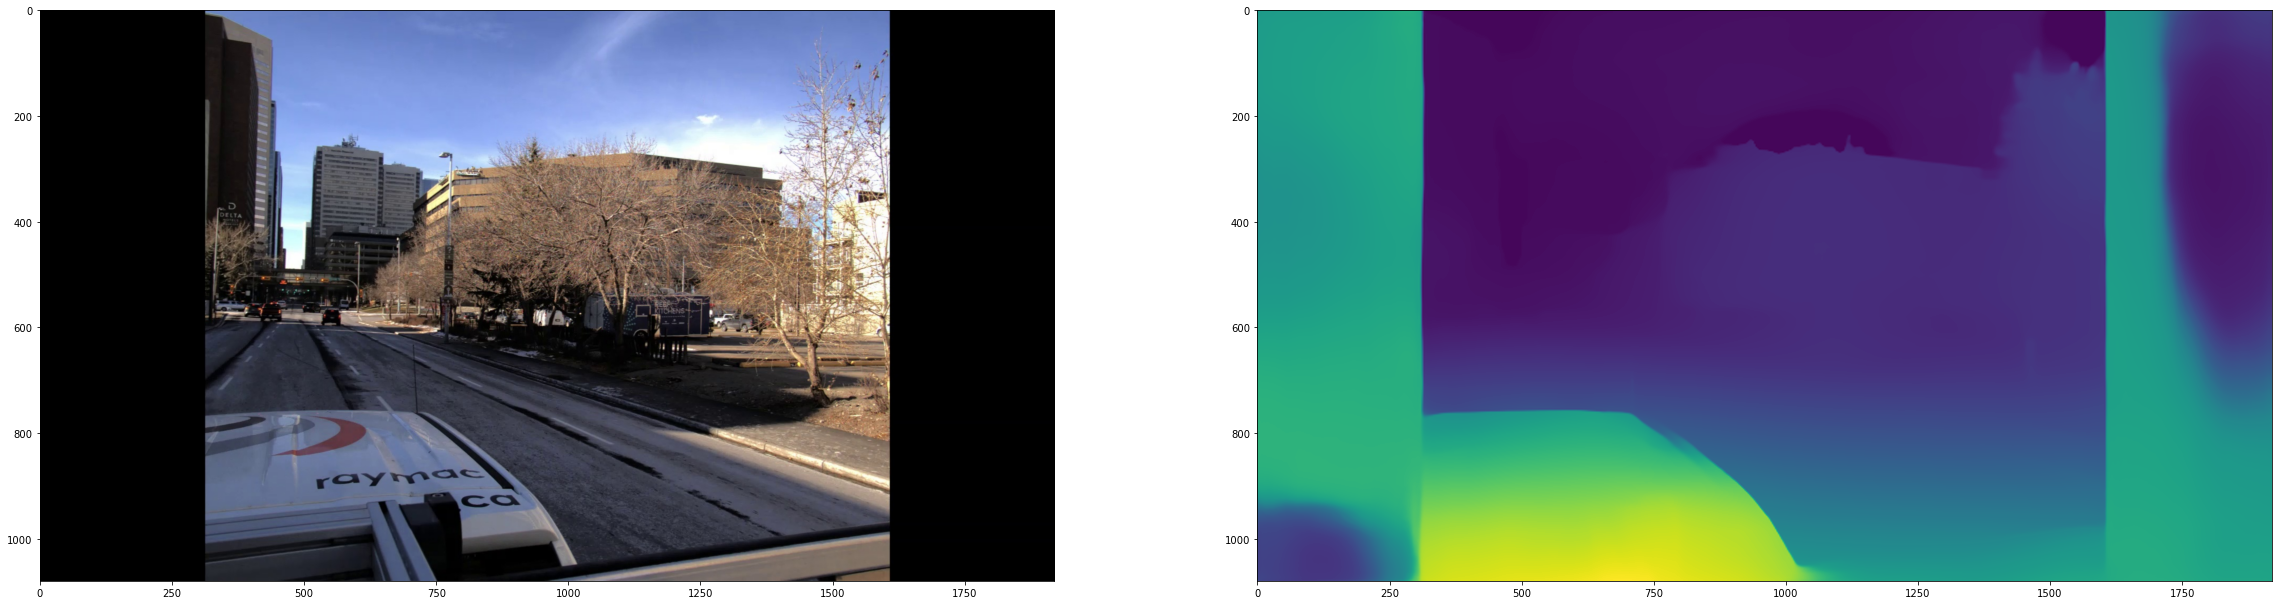

In [248]:
f, axarr = plt.subplots(1,2)

f.set_figheight(20)
f.set_figwidth(40)

axarr[0].imshow(img)
axarr[1].imshow(predictions_arr)

In [250]:
# save plot
f.savefig('output_result/54.png')

# Measure invocation time 

In [254]:
inferenceTime_list=[]
for i in range(10):
    body = io.open(path, 'rb')
    t0 = time.time()
    rv = client.invoke_endpoint(EndpointName=uncompiled_predictor.endpoint_name, Body=body, ContentType=content_type)
    t1 = time.time()

    time_elapsed = (t1-t0)*1000
    inferenceTime_list.append(time_elapsed)
    print(time_elapsed)

2742.748975753784
2541.4199829101562
2556.5035343170166
2503.575086593628
2598.672389984131
2535.305976867676
2511.230230331421
2836.294412612915
2538.0184650421143
2510.0882053375244


In [255]:
np.mean(inferenceTime_list)

2587.3857259750366

# Async endpoint

In [9]:
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig

bucket= 'gulogulo-inference-results'

async_config = AsyncInferenceConfig(
                output_path= f"s3://{bucket}/output",
                max_concurrent_invocations_per_instance=2,)


In [10]:
framework_version = '1.7.1'
py_version = 'py36'
env= {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '2000000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }

sm_model = PyTorchModel(model_data=model_url,
                               framework_version=framework_version,
                               role=role,
                               sagemaker_session=sess,
                               entry_point='inference.py',
                               source_dir= 'code-async',
                               env=env,
                               py_version=py_version
                              )

In [11]:
instance_type = 'ml.g4dn.xlarge'
async_uncompiled_predictor = sm_model.deploy(async_inference_config=async_config,
                                       initial_instance_count=1,
                                       instance_type=instance_type)

-----------!

# Test endpoint

In [12]:
endpoint_name= 'pytorch-inference-2022-10-04-20-02-58-057'

In [13]:
input_1_s3_location= 's3://gulogulo-inference-images/frame92.jpg'

In [15]:
input_1_s3_location= 's3://gulogulo-inference-images/GuloGulo_2022_09_26_15_02_53.mp4'

In [19]:
input_1_s3_location= 's3://gulogulo-inference-images/Week_0-2_planar2.mp4'

### Invoke async endpoint

In [20]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://gulogulo-inference-results/output/60a6edc8-24dd-4237-836b-35136a7b3b34.out
